In [1]:
## Import libraries
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

### 1. Loading the data

#### 1.1- Binary alphadigits

In [5]:
## Unzip the data
import zipfile
import os

zif_data = "./data.zip"

destination_folder = "./"

with zipfile.ZipFile(zif_data, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)




In [6]:
##  AlphaDigits dataset
path_AlDi = './data/binaryalphadigs.mat'
data_alphadigits = loadmat(path_AlDi) 

In [7]:
data_alphadigits.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dat', 'numclass', 'classlabels', 'classcounts'])

In [8]:
print(data_alphadigits['dat'].shape) ## shape (36,39) : 36 letters, 39 samples per letter
print(data_alphadigits['dat'][0][0].shape) ## shape (20,16), the first A

(36, 39)
(20, 16)


In [9]:
data_alphadigits['classlabels'].reshape(-1) ## 36 letters

array([array(['0'], dtype='<U1'), array(['1'], dtype='<U1'),
       array(['2'], dtype='<U1'), array(['3'], dtype='<U1'),
       array(['4'], dtype='<U1'), array(['5'], dtype='<U1'),
       array(['6'], dtype='<U1'), array(['7'], dtype='<U1'),
       array(['8'], dtype='<U1'), array(['9'], dtype='<U1'),
       array(['A'], dtype='<U1'), array(['B'], dtype='<U1'),
       array(['C'], dtype='<U1'), array(['D'], dtype='<U1'),
       array(['E'], dtype='<U1'), array(['F'], dtype='<U1'),
       array(['G'], dtype='<U1'), array(['H'], dtype='<U1'),
       array(['I'], dtype='<U1'), array(['J'], dtype='<U1'),
       array(['K'], dtype='<U1'), array(['L'], dtype='<U1'),
       array(['M'], dtype='<U1'), array(['N'], dtype='<U1'),
       array(['O'], dtype='<U1'), array(['P'], dtype='<U1'),
       array(['Q'], dtype='<U1'), array(['R'], dtype='<U1'),
       array(['S'], dtype='<U1'), array(['T'], dtype='<U1'),
       array(['U'], dtype='<U1'), array(['V'], dtype='<U1'),
       array(['W'], dtyp

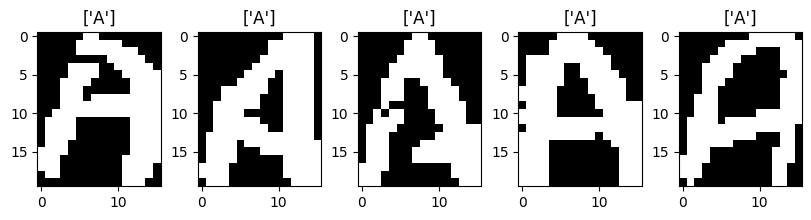

In [10]:
## visualize the first 5 A
fig, ax = plt.subplots(1,5, figsize=(10,2))
for i in range(5):
    ax[i].imshow(data_alphadigits['dat'][10][i].reshape(20,16), cmap='gray')
    ax[i].set_title(data_alphadigits['classlabels'][0][10])
plt.show()

#### 1.2- MNIST dataset

In [ ]:
## Uncomment below to load the mnist dataset from keras
! pip install keras

In [14]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test)  = mnist.load_data()

In [15]:
print(X_train.shape) ## (60000, 28, 28)
print(y_train.shape) ## (60000,)
print(X_test.shape) ## (10000, 28, 28)
print(y_test.shape) ## (10000,)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


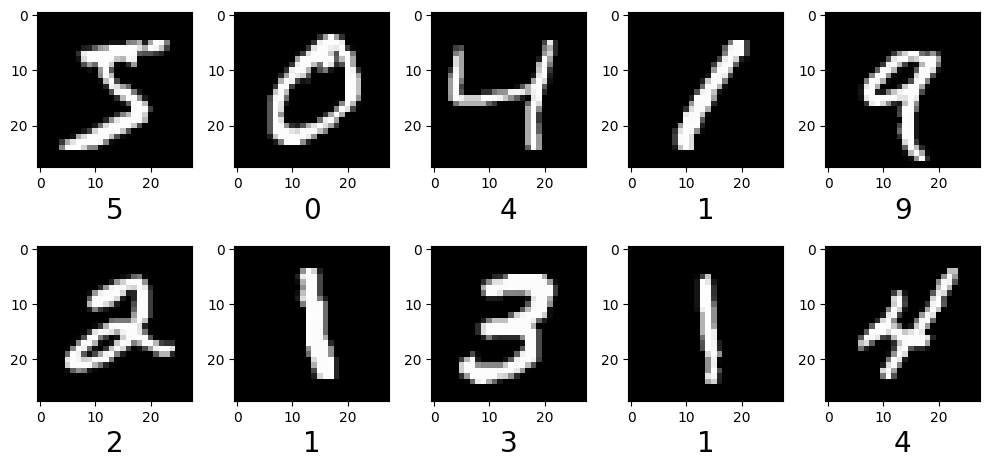

In [16]:
## plot the first 10 digits

def plot_mnist(data, labels):
    fig, ax = plt.subplots(2,5)
    fig.set_size_inches(10, 5)
    for i, axi in enumerate(ax.flat):
        # plt.subplot(2, 5, i+1)
        axi.imshow(data[i], cmap='gray')
        axi.set_xlabel(labels[i], fontsize = 20)
    plt.tight_layout()
    plt.show()
plot_mnist(X_train, y_train)

### 2. Useful methods

#### 2.1- lire_alpha_digits()

In [150]:
# data_alphadigits['classlabels'].flatten().tolist()

In [17]:
## Retrieving all the labels/characters
char_list_all = []
for array in data_alphadigits['classlabels'][0]:
    char_list_all.append(array[0])


In [18]:
def char_to_index(char):
    '''
    Convert a character to its corresponding index in the dataset
    '''
    assert char in char_list_all, "character not in the 36 digits categories"
    return char_list_all.index(char)

In [19]:
def lire_alpha_digit(data, char_list):
    X = []
    y = []
    char_list = np.unique([char.upper() for char in char_list])
    for char in char_list:
        for i in range(39):
            X.append(data['dat'][char_to_index(char)][i].reshape(1,-1))
        y.append(char)
    return np.concatenate(X), np.array(y)

In [21]:
### Test
set_ABC = lire_alpha_digit(data_alphadigits, ['a','F', '0','B','9','b','c'])
print(set_ABC[0].shape, set_ABC[1]) 

(234, 320) ['0' '9' 'A' 'B' 'C' 'F']


#### 2.2- convert_mnist_BW()

In [22]:
def convert_mnist_black_white(X, threshold = 127):
    '''
    Convert a 3D array of mnist images to 3D array of black and white images
    '''
    X_bw = []
    for i in range(X.shape[0]):
        X_bw.append(np.where(X[i] > threshold, 1, 0))
    return np.stack(X_bw, axis = 0)

In [23]:
X_train_bw = convert_mnist_black_white(X_train)

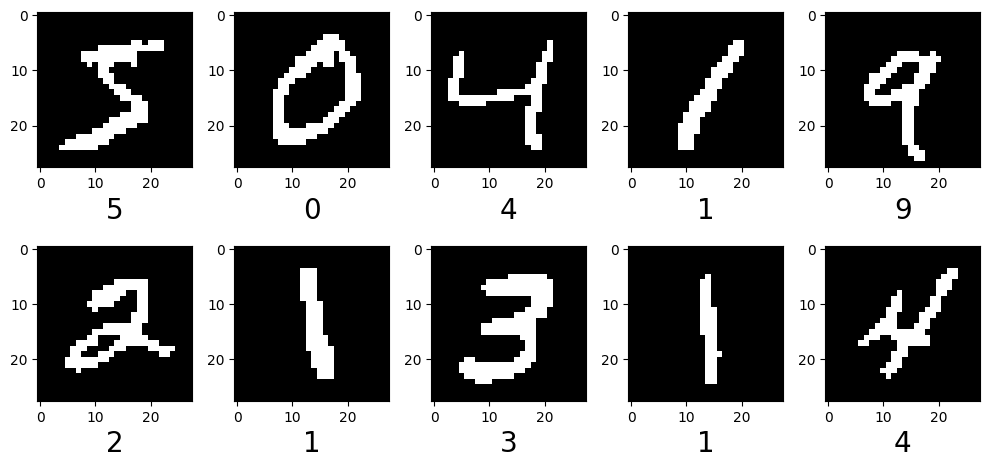

In [24]:
plot_mnist(X_train_bw[:10], y_train[:10])

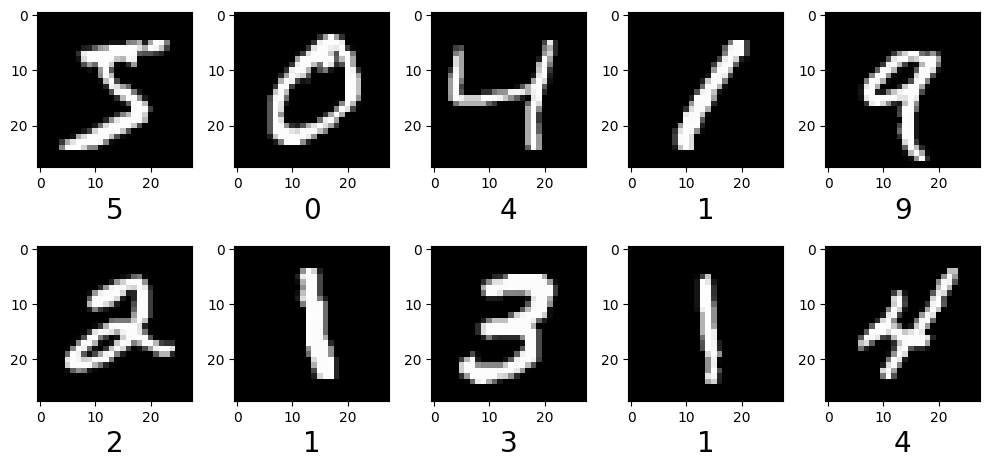

In [25]:
plot_mnist(X_train[:10], y_train[:10])

## 3. Restricted Boltzman Machine (RBM)

In [26]:
def init_RBM(input_size, output_size):
    '''
    Initialize the parameters of the RBM
    '''
    a = np.zeros((1, input_size))
    b = np.zeros((1, output_size))
    W = np.random.normal(0, 0.01, (input_size, output_size))
    return a, b, W

In [27]:
## Test
RBM = init_RBM(320, 36)

In [29]:
def entree_sortie_RBM(RBM, V):
    '''
    Compute the output of the RBM
    V : input data, visible, shape (n_samples, input_size)
    '''
    _, b, W = RBM
    return 1/(1 + np.exp(-(np.dot(V, W) + b))) ## shape (n_samples, output_size)

In [30]:
def sortie_entree_RBM(RBM, H):
    '''
    Compute the input of the RBM
    H : output data, hidden, shape (n_samples, output_size)
    '''
    a, _, W = RBM
    return 1/(1 + np.exp(-(np.dot(H, W.T) + a))) ## shape (n_samples, input_size)

In [31]:
def train_RBM(RBM, input_data, n_epochs = 1, lr=1e-3, batch_size =8, verbose = True):
    '''
    Train the RBM
    '''
    a, b, W = RBM
    n_samples = input_data.shape[0]
    for epoch in range(n_epochs):
        for i in range(0, n_samples//batch_size * batch_size, batch_size):
            V = input_data[i:i+batch_size].reshape(batch_size, -1)
            H = entree_sortie_RBM(RBM, V)
            V_prime = sortie_entree_RBM(RBM, H)
            H_prime = entree_sortie_RBM(RBM, V_prime)
            a += lr * (V - V_prime).sum(axis = 0)
            b += lr * (H - H_prime).sum(axis = 0)
            W += lr * (np.dot(V.T, H) - np.dot(V_prime.T, H_prime))
        if verbose:
            print('Epoch %d/%d' % (epoch+1, n_epochs))
    return a, b, W

In [32]:
set_ACW, _ = lire_alpha_digit(data_alphadigits, ['a','c','w'])

In [37]:
trained_RBM = train_RBM(RBM, set_ACW, n_epochs = 100, lr=1e-3, batch_size =16, verbose = True)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [259]:
### Test 
## Sample 10 images from the trained RBM

In [38]:
def generer_image_RBM(n_iter_gibbs = 50, n_samples=10, trained_RBM = trained_RBM):
    '''
    Generate images from the trained RBM
    '''
    a, b, W = trained_RBM
    V = np.random.binomial(1, 0.5, (n_samples, a.shape[1])) ## initialize each component of V to bernoulli(0.5)
    #print(V)
    plt.imshow(V[0].reshape(20,16), cmap='gray')
    for i in range(n_iter_gibbs):
        
        ## This 
        H = entree_sortie_RBM(trained_RBM, V)
        V = sortie_entree_RBM(trained_RBM, H)
        
        ## or this
        H = np.random.binomial(1, entree_sortie_RBM(trained_RBM, V))
        V = np.random.binomial(1, sortie_entree_RBM(trained_RBM, H))
        
        ## or this 
        H = np.array([1 if value >= 0.5 else 0 for row in entree_sortie_RBM(RBM, V) for value in row]).reshape(n_samples, -1)
        V = np.array([1 if value >= 0.5 else 0 for row in sortie_entree_RBM(RBM, H) for value in row]).reshape(n_samples, -1)
    plt.imshow(V[0].reshape(20,16), cmap='gray')
    return V

In [35]:
list(map(lambda x : 1 if x >=0.5 else 0, [0.4, 0.5, 0.6]))

[0, 1, 1]

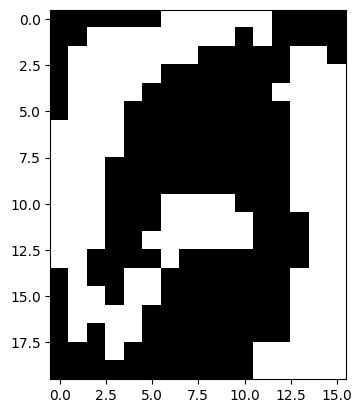

In [48]:
sampled_images = generer_image_RBM(n_iter_gibbs = 10, n_samples=1, trained_RBM = trained_RBM)